# Анализ поведения преподавателей в онлайн-школе

<div style="border:solid green 2px; padding: 20px">

<font size = 5> ***Цель исследования:*** </font>

<font size = 4> Определить предвесники снижения активности преподавателей и предсказать будущий отток. </font>

<div style="border:solid green 2px; padding: 20px">

<font size = 5> ***Задачи, поставленные заказчиком:*** </font>
   
<font size = 4> 1. Анализ активности преподавателей; </font>
    
<font size = 4> 2. Выделить 2-3-5 ключевых признаков (”флагов”) потенциального оттока преподавателей; </font>

<font size = 4> 3. Сформулировать набор критериев, по которому разметить “близких к оттоку” преподавателей; </font>

<font size = 4> 4. Сформировать набор критериев будущего churn’а (с обоснованием и приоритизацией); </font>

<font size = 4> 5. Сформировать список преподавателей “at risk”.  </font>
    

# Содержание
* **1 [Загрузка данных](#1)**
* **2 [Исследовательский анализ данных (EDA)](#2)**
  * **2.1  [Динамика количества уроков и клиентов сервиса за 4 года ](#21)**
  * **2.2  [Определяем "лайфтайм" специалистов, определяем среднее количество учеников, уроков в месяц, месяц с максимальной и минимальной нагрузкой, делим специалистов на 2 группы (ушел/остался)](#22)**
  * **2.3  [Изучаем средние значения и стандартные отклонения](#23)**
* **3  [Формируем и проверяем гипотезы](#3)**
* **4 [Машинное обучение](#4)**
  * **4.1 [Строим матрицу корреляций](#41)**
  * **4.2 [Подготовка данных для машинного обучения](#42)**
  * **4.3 [Обучение моделей](#43)**
  * **4.4 [Прогнозирование](#44)**
* **5 [Оценка значимости признаков](#5)** 
* **6 [Выводы](#6)**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from math import sqrt
from scipy import stats as st
import numpy as np
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

<a id='1'></a>
## 1. Загрузка данных

**По договоренности с заказчиком в данном  проекте не показаны исходные данные и блоки, где исходные данные раскрываются в явном виде** 


Данные представлены за последние 4 года

In [2]:
teacher=pd.read_csv('/home/julia/Рабочий стол/Портфолио/teacher.csv')
teacher.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25343 entries, 0 to 25342
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   teacher_id  25343 non-null  int64 
 1   date        25343 non-null  object
 2   lessons     25343 non-null  int64 
 3   users       25343 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 792.1+ KB


<a id='2'></a>
## 2. Исследовательский анализ данных (EDA)

* Для сравнения преподавателей, нам нужно определить для каждого специалиста - месяц начала работы, последний месяц работы, вычислить 'лайфтайм' и перевести даты в порядковые номера месяцев с начала работы. Таким образом мы сможем отследить динамику уроков в течение периода работы преподавателя. 
* Определим среднее количество уроков и учеников в месяц. 
* Макисмально и минимально продуктивный месяцы. 

Но для начала, нужно определиться с динамикой количества уроков и количеством учеников сервиса в целом, так как представленный период времени совпал с глобальными социальными потрясениями: пандемия, спецоперация, экономический кризис.

<a id='21'></a>
### 2.1 Динамика количества уроков  и учеников сервиса  за 4 года 

По причинам, изложенным выше, показать исходные данные не представляется возможным. Далее приведен только вывод.  

**Комментарий:** Как мы видим, на графике параметры: количество уроков и количество учеников, ожидаемо имеют схожие кривые. Количество специалистов также постепенно увеличивается, но естественно не так заметно, как рост количества клиентов и сессий.  Также мы видим, что количествово уроков и учеников начинает расти с 2020 года, достигая максимума в 2022 году. При этом данные за последний месяц наблюдений -  во много раз ниже предыдущего, что скорее всего связвно с тем, что данные собраны не за целый месяц. Цикличность (сезонность) не прослеживается, мы видим явный постепенный рост без колебаний (один небольшой спад по количеству уроков в конце 2021 года, но на кривой кол-ва учеников он не такой явный - стоит обратить на это внимание заказчика). Важно учесть небольшое количество уроков и учеников  в первые два года работы сервиса. Поведение преподавателей в этот период (когда сервис еще не так популярен) может отличаться от поведения на сегодняшний день. 

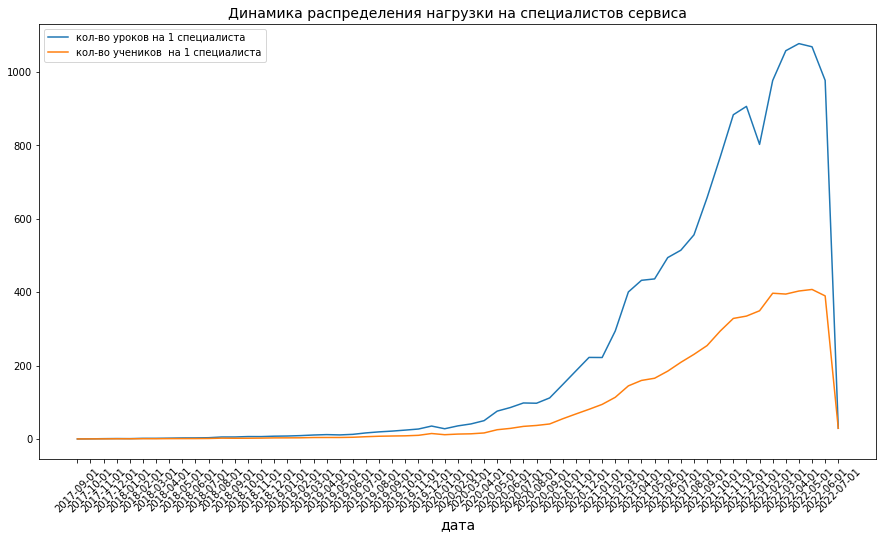

In [3]:
def teach (x):
    data=x.pivot_table(index='date' , aggfunc={'lessons':'sum', 
                                                     'users':'sum', 
                                                     'teacher_id':'nunique' }).reset_index()
    data['lessons_th']=data['lessons']/data['teacher_id'].nunique()
    data['users_th']=data['users']/data['teacher_id'].nunique()
    return data

data=teach(teacher)

plt.figure(figsize=(15, 8))
plt.plot(data['date'],  data['lessons_th'])
plt.plot(data['date'],  data['users_th'])
plt.grid(axis='date', color='0.95', rotation=45)
plt.xticks(rotation=45)
plt.legend(labels=['кол-во уроков на 1 специалиста', 'кол-во учеников  на 1 специалиста'])
plt.title('Динамика распределения нагрузки на специалистов сервиса', fontsize=14)
plt.xlabel('дата', fontsize=14)

plt.show()

**Вывод:** Мы видим, что нагрузка на специалистов сервиса растет неравномерно. Резкий рост количества уроков на одного специалиста начинается с мая 2018 года. Максимальная нагрузка отмечается в мае 2020 года (совпадает с периодом самоизоляции). Также мы видим снижение нагрузки в конце 2021 года, что связано с оттком учеников (который мы видели на предыдущем графике). 


**Решение:** Мы однозначно не будем учитывать в исследовании данные за последний месяц, так как они могут быть неполными. Отбросим выпадающие значения (для этого воспользуемся методом quantile для определения нижней и верхней границ): отбросим месяцы с нагрузкой на специалистов значительно отличающейся от средней. 

In [4]:
def emissions(i):
    lower_bound = i.quantile(q=0.025).round(0)
    upper_bound = i.quantile(q=0.975).round(0)
    return lower_bound, upper_bound

teacher=teacher[teacher['date'] < '2022-07-01']
data=teach(teacher)
lessons=emissions(data['lessons_th'])
users=emissions(data['users_th'])
print(f'Границы количества уроков на 1 специалиста: {lessons}')
print(f'Границы количества учеников на 1 специалиста: {users}')


Границы количества уроков на 1 специалиста: (1.0, 1083.0)
Границы количества учеников на 1 специалиста: (0.0, 408.0)


**Комментарий:** Оценив границы "выпадающих значений" нельзя выделить месяцы с выпадающими значениями, следовательно период наблюдения с сентября 2019 по июнь 2022 года. 

<a id='22'></a>
### 2.2 Определяем "лайфтайм" специалистов, определяем среднее количество учеников, уроков в месяц, месяц с максимальной и минимальной нагрузкой, делим специалистов на 2 группы (ушел/остался)

Определяем лайфтайм преподавателей.

In [5]:
#находим первый и последний месяц работы
start = (teacher.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'first'})
        .rename(columns={'date': 'first_date'})
        .reset_index())

end=(teacher.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'last'})
        .rename(columns={'date': 'last_date'})
        .reset_index())
df_1=teacher.merge(start, how='left').merge(end, how='left')
df_1['date']=pd.to_datetime(df_1['date'])
df_1['first_date']=pd.to_datetime(df_1['first_date'])
df_1['last_date']=pd.to_datetime(df_1['last_date'])

#определяем продолжительность работы в месяцах
df_1['lifetime'] = (((df_1['date'] - df_1['first_date']).dt.days)/30).round(0)




#создаем сводную таблицу по специалистам: id специалиста, продолжительность работы в месяцах, среднее количество 
# уроков и учеников в месяц, доля учеников и уроков в последний месяц работы (от среднего количества)
data=df_1.pivot_table(index='teacher_id', aggfunc={'lifetime':'max',
                                                  'lessons':'mean',
                                                  'users':'mean'}).reset_index()
data_1=(df_1.query('date==last_date')[['teacher_id', 'lessons', 'users']]
        .rename(columns={'lessons': 'last_lessons', 'users':'last_users'}))
data=data.merge(data_1, how='left')
data['last_lessons']=data['last_lessons']/data['lessons']*100
data['last_users']=data['last_users']/data['users']*100


#определяем статус специалиста (ушел/работает)
def ch(i):
    if i in churn:
        return 0
    else:
        return 1
churn=df_1[df_1['last_date'] == '2022-06-01']['teacher_id'].unique()
data['churn']=data['teacher_id'].apply(ch)

<a id='23'></a>
### 2.3 Изучаем средние значения и стандартные отклонения

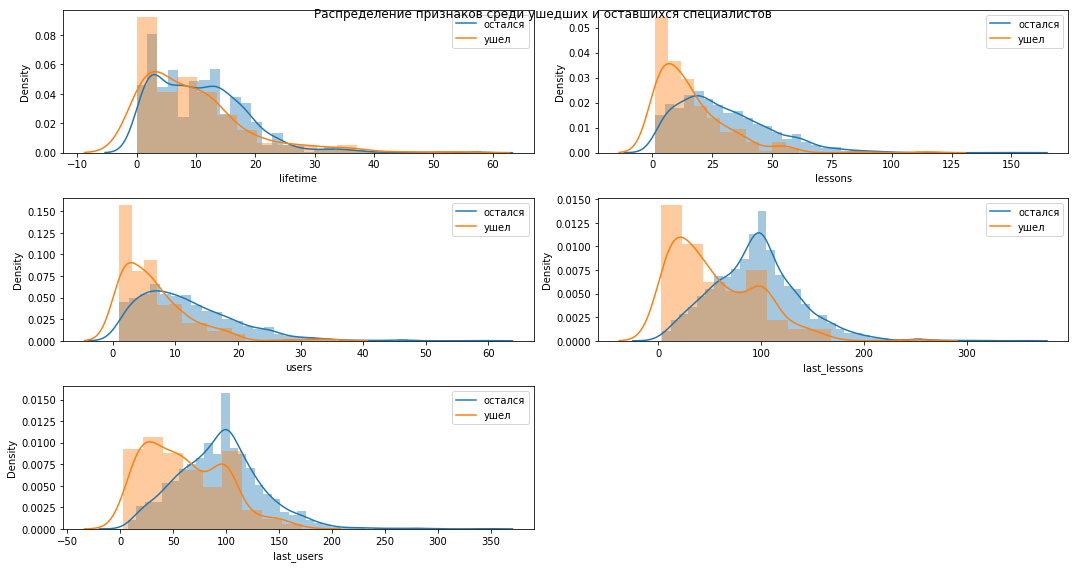

In [6]:
signs=['lifetime', 'lessons',  'users', 'last_lessons', 'last_users']


col_count, row_count = 2,3
plt.figure(figsize=(15, 8))

for i, n in enumerate(signs):
    for churn in data['churn'].unique():
        cur=data.query('churn==@churn')
        sns.distplot(cur[n], ax=plt.subplot(row_count, col_count, i+1))
    
    plt.legend(labels=['остался', 'ушел'])
plt.suptitle('Распределение признаков среди ушедших и оставшихся специалистов')

plt.tight_layout()


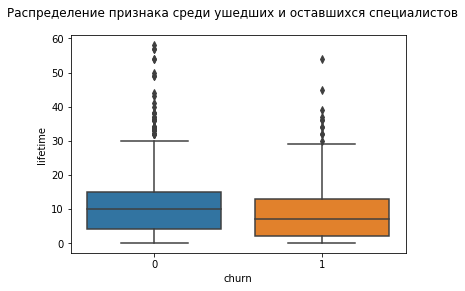

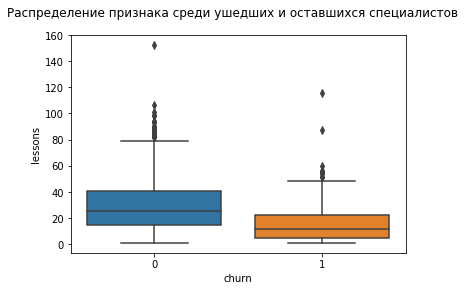

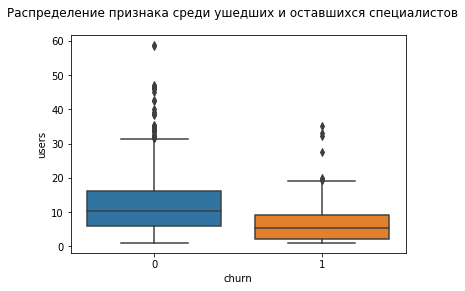

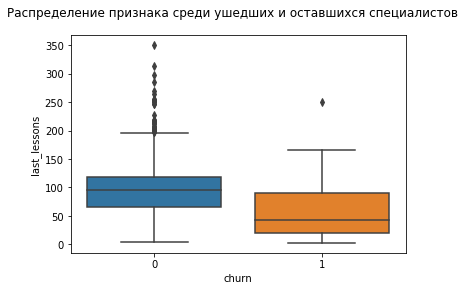

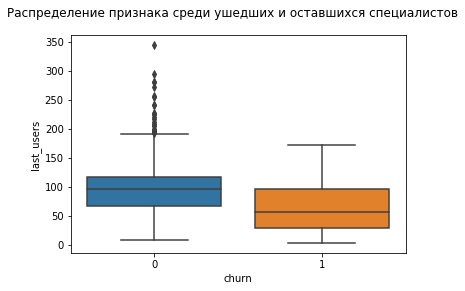

In [7]:
for i in signs:
    sns.boxplot(x=data['churn'] , y=data[i], data=data)
    plt.suptitle('Распределение признака среди ушедших и оставшихся специалистов')
    plt.show()

In [8]:
display(data.query('churn==1').describe())
display(data.query('churn==0').describe())

,teacher_id,lessons,lifetime,users,last_lessons,last_users,churn
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.0
mean,1066.676692,15.938849,9.402256,6.615833,54.475033,60.567749,1.0
std,687.212555,15.191480,8.935399,5.636445,41.651211,37.188005,0.0
min,4.000000,1.000000,0.000000,1.000000,2.592036,2.846535,1.0
25%,537.750000,4.678571,2.000000,2.234848,20.223881,28.892680,1.0
50%,1011.500000,11.973684,7.000000,5.450000,43.643707,56.385870,1.0
75%,1672.250000,22.486111,13.000000,9.068056,89.711254,95.120321,1.0
max,2483.000000,115.739130,54.000000,35.130435,250.000000,171.428571,1.0


,teacher_id,lessons,lifetime,users,last_lessons,last_users,churn
count,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000,1890.0
mean,1372.704233,29.463925,10.752910,11.819597,95.225825,94.056422,0.0
std,705.690806,19.204571,8.004948,7.791223,42.722417,40.084437,0.0
min,1.000000,1.000000,0.000000,1.000000,3.496503,7.023411,0.0
25%,784.250000,14.955882,4.000000,6.000000,66.192012,66.005792,0.0
50%,1376.500000,25.788889,10.000000,10.250000,94.932375,95.238095,0.0
75%,1958.750000,40.842857,15.000000,16.186080,118.675793,116.666667,0.0
max,2644.000000,152.187500,58.000000,58.666667,350.000000,343.750000,0.0


**Вывод:** Уже сейчас мы можем предположить, что продолжительность работы скорее всего не влияет на отток специалистов, при этом мы можем предположить, что  нагрузка ушедших сотрудников меньше  нагрузки сотрудников, которые остались. 

<a id='3'></a>
## 3. Формируем и проверяем гипотезы

Для снижения вероятности групповой ошибки при одновременной проверке нескольких гипотез на том же наборе данных пересчитаем статистический уровень значимости с учетом Поправки Бонферрони: (alfa/количество проверяемых гипотез),  в нашем случае 0,05/5

In [9]:
#создаем функцию для проверки гипотезы
def stat(a, b):
    alpha = .05/5 

    results = st.ttest_ind(a, b, equal_var = False)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 
    

In [10]:
lost=data.query('churn==1').drop(columns=['churn'], axis=1)
stay=data.query('churn==0').drop(columns=['churn'], axis=1)
print('Количество ушедших преподавателей:', lost['teacher_id'].nunique())
print('Количество оставшихся преподавателей:', stay['teacher_id'].nunique())

Количество ушедших преподавателей: 266
Количество оставшихся преподавателей: 1890


**Первая гипотеза:** 
* Нулевая гипотеза: Средняя продолжительность работы (в месяцах) у оставшихся и ушедших специалистов достоверно не различается. 
* Альтернативная гипотеза: Средняя продолжительность работы (в месяцах) у оставшихся и ушедших специалистов достоверно  различается.    

In [11]:
stat(lost['lifetime'], stay['lifetime'])

p-значение: 0.020048726907287845
Не получилось отвергнуть нулевую гипотезу


**Вторая гипотеза:** 
* Нулевая гипотеза: Среднее количество уроков в месяц у оставшихся и ушедших специалистов достоверно не различается. 
* Альтернативная гипотеза: Среднее количество уроков в месяц у оставшихся и ушедших специалистов достоверно  различается.  

In [12]:
stat(lost['lessons'], stay['lessons'])

p-значение: 6.887053957252724e-33
Отвергаем нулевую гипотезу


**Третья гипотеза:** 
* Нулевая гипотеза: Среднее количество учеников в месяц у оставшихся и ушедших специалистов достоверно не различается. 
* Альтернативная гипотеза: Среднее количество учеников в месяц у оставшихся и ушедших специалистов достоверно  различается.

In [13]:
stat(lost['users'], stay['users'])

p-значение: 3.1074545851047226e-34
Отвергаем нулевую гипотезу


**Четвертая гипотеза:** 
* Нулевая гипотеза: Доля уроков  в последний месяц работы (от среднего количества) у оставшихся и ушедших специалистов достоверно не различается. 
* Альтернативная гипотеза: Доля уроков  в последний месяц работы (от среднего количества) у оставшихся и ушедших специалистов достоверно  различается.

In [14]:
stat(lost['last_lessons'], stay['last_lessons'])

p-значение: 3.7164778029639925e-39
Отвергаем нулевую гипотезу


**Четвертая гипотеза:** 
* Нулевая гипотеза: Доля учеников  в последний месяц работы (от среднего количества) у оставшихся и ушедших специалистов достоверно не различается. 
* Альтернативная гипотеза: Доля учеников  в последний месяц работы (от среднего количества) у оставшихся и ушедших специалистов достоверно  различается.

In [15]:
stat(lost['last_users'], stay['last_users'])

p-значение: 2.661491158294133e-34
Отвергаем нулевую гипотезу


**Вывод:** Как мы и предполагали, продолжительность работы в группах ушедших и оставшихся специалистов достоверно не различается. Но при этом выявлены достоверные различия в средней нагрузке и нагрузке в последний месяц работы. 

<a id='4'></a>
## 4. Машинное обучение

<a id='4.1'></a>
### 4.1 Строим матрицу корреляций

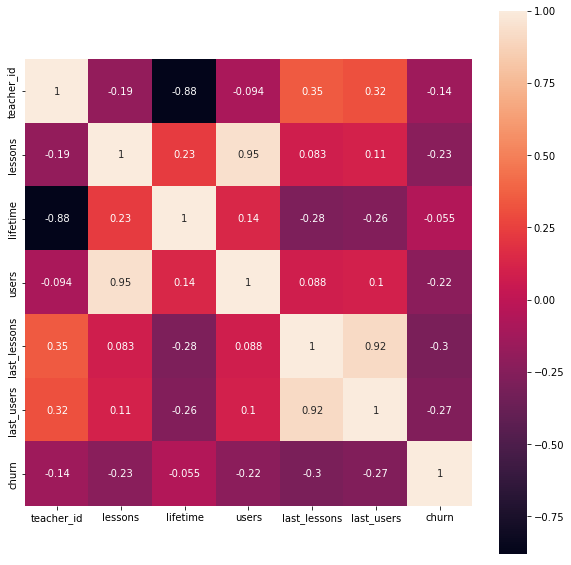

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, square=True)
plt.show()

Ожидаемо, что количество учеников и количество уроков являются влияющими друг на друга признаками. 
Перед проведением машинного обучения необходимо избавиться от одного из влияющих признаков. Размышляя логически, количество уроков - признак который больше отражает нагрузку на специалиста, чем количество учеников. 

<a id='4.2'></a>
### 4.2 Подготовка данных для машинного обучения

Для начала разделим данные на 2 категории - данные на которых мы будем обучать и тестировать модель и данные, которые мы будем анализировать. 
Обучать и тестировать данные мы будем на выборке до июня 2022 года. А анализировать специалистов, которые остались работать в июне.  

In [17]:
df_2=teacher[teacher['date'] < '2022-06-01']
start = (df_2.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'first'})
        .rename(columns={'date': 'first_date'})
        .reset_index())

end=(df_2.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'last'})
        .rename(columns={'date': 'last_date'})
        .reset_index())

df_2=df_2.merge(start, how='left').merge(end, how='left')
df_2['date']=pd.to_datetime(df_2['date'])
df_2['first_date']=pd.to_datetime(df_2['first_date'])
df_2['last_date']=pd.to_datetime(df_2['last_date'])
df_2['lifetime'] = (((df_2['date'] - df_2['first_date']).dt.days)/30).round(0)


data=df_2.pivot_table(index='teacher_id', aggfunc={'lifetime':'max',
                                                  'lessons':'mean'}).reset_index()
                                                   
data_1=(df_2.query('date==last_date')[['teacher_id', 'lessons']]
        .rename(columns={'lessons': 'last_lessons'}))
data=data.merge(data_1, how='left')


data['last_lessons']=data['last_lessons']/data['lessons']*100
churn=df_2[df_2['last_date'] == '2022-05-01']['teacher_id'].unique()
data['churn']=data['teacher_id'].apply(ch)


In [18]:
#Делим данные на признаки и целевую переменную 
x = data.drop(['churn', 'teacher_id'], axis=1)
y = data['churn'] 

#проводим разделение на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y)

<a id='4.3'></a>
### 4.3 Обучение моделей

Обучаем модель с применением логистической регрессии

In [19]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
probabilities = model.predict_proba(x_test)[:,1]
#рассчитываем метрики
def metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

metrics(y_test, predictions,probabilities,
        title='Метрики для модели логистической регрессии:')


Метрики для модели логистической регрессии:
	Accuracy: 0.89
	Precision: 0.47
	Recall: 0.16
	F1: 0.23
	ROC_AUC: 0.84


Обучаем модель с использованием случайного леса:

In [20]:
t_model = RandomForestClassifier(random_state=0)
t_model.fit(x_train, y_train)
t_predictions = t_model.predict(x_test)
t_probabilities = t_model.predict_proba(x_test)[:, 1]

metrics(y_test, t_predictions,t_probabilities,
        title='Метрики для модели случайный лес:')


Метрики для модели случайный лес:
	Accuracy: 0.89
	Precision: 0.52
	Recall: 0.36
	F1: 0.42
	ROC_AUC: 0.83


**Вывод:** Обученные модели обладают низкой специфичностью и низкой чувствительностью, что неудивительно, так как мы оцениваем малое количество признаков. Не учитываются такие признаки, как уровень заработной платы (в динамике), уровень образования, повышение квалификации, возраст, количество отмененных сессий, больничне листы и т.д.

Для прогнозирования будем использовать случайный лес, эта модель более чувствительна, по остальным метрикам разница между моделями не видна. 

<a id='4.4'></a>
### 4.4 Прогнозирование

Подготовим данные для прогнозирования: 

In [21]:
forecast=teacher[teacher['date']== '2022-06-01']['teacher_id'].unique()
df=teacher.query('teacher_id in @forecast')

In [22]:
start = (df.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'first'})
        .rename(columns={'date': 'first_date'})
        .reset_index())

end=(df.sort_values(by=['teacher_id', 'date'])
        .groupby('teacher_id')
        .agg({'date': 'last'})
        .rename(columns={'date': 'last_date'})
        .reset_index())

df=df.merge(start, how='left').merge(end, how='left')
df['date']=pd.to_datetime(df['date'])
df['first_date']=pd.to_datetime(df['first_date'])
df['last_date']=pd.to_datetime(df['last_date'])
df['lifetime'] = (((df['date'] - df['first_date']).dt.days)/30).round(0)

data=df.pivot_table(index='teacher_id', aggfunc={'lifetime':'max',
                                                  'lessons':'mean'}).reset_index()
                                                   
data_1=(df.query('date==last_date')[['teacher_id', 'lessons']]
        .rename(columns={'lessons': 'last_lessons'}))
data=data.merge(data_1, how='left')
data['last_lessons']=data['last_lessons']/data['lessons']*100
churn=df[df['last_date'] == '2022-05-01']['teacher_id'].unique()
data['churn']=data['teacher_id'].apply(ch)


In [23]:
X = data.drop(['churn', 'teacher_id'], axis=1)
 

In [24]:
labels=t_model.predict(X)
data['forecast'] = labels


In [25]:
a=data.query('forecast==1')['teacher_id'].unique()

print(f'Кол-во специалистов "at risk": {len(a)}')
print(f'Список специалистов "at risk": {list(a)}')

Кол-во специалистов "at risk": 70
Список специалистов "at risk": [41, 72, 115, 118, 124, 226, 233, 441, 812, 874, 904, 957, 992, 1000, 1041, 1076, 1149, 1154, 1177, 1212, 1217, 1240, 1277, 1295, 1321, 1323, 1351, 1352, 1394, 1405, 1412, 1448, 1552, 1598, 1705, 1715, 1734, 1800, 1814, 1838, 1845, 1850, 1885, 1907, 1937, 1991, 1998, 2000, 2014, 2053, 2069, 2080, 2088, 2099, 2123, 2237, 2276, 2341, 2347, 2377, 2385, 2425, 2432, 2490, 2510, 2560, 2568, 2595, 2609, 2611]


<a id='5'></a>
## 5 Оценка значимости признаков

In [26]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

scores = [0.8766756  0.91432827 0.89448913 0.85033894 0.85785544] 
mean score = 0.87874 +/- 0.02350


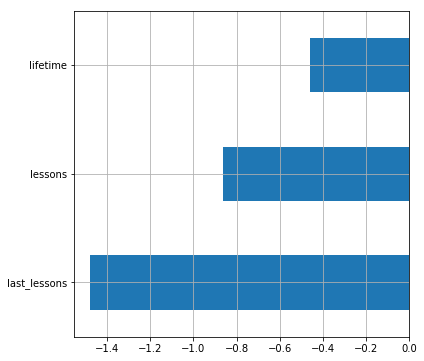

In [27]:
SEED = 1
lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])
scores = cross_val_score(estimator=lr, X=x, y=y, 
                         cv=None, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=x, target=y, column_names=x.columns, model_type='lr')


**Вывод:** Наиболее значимый для прогноза признак: доля проведенных в последний месяц уроков от среднемесячного значения. На втором месте по значимости среднемесячное количество уроков. Продолжительность работы меньше всего влияет на прогнозирование оттока специалистов. 

<a id='5'></a>
### 6. Выводы:

* Достоверные **различия** в группах оставшихся и ушедших специалистов **выявлены по среднемесячному количеству уроков и учеников, по количеству уроков и учеников в последний месяц работы**. У группы ушедших специалистов эти показатели достоверно ниже. По продолжительности работы в сервисе достоверные различия в группах не выявлены. 
* **Наиболее значимый для прогноза оттока специалистов признак: доля проведенных в последний месяц уроков** от среднемесячного значения. На втором месте по значимости среднемесячное количество уроков. Продолжительность работы меньше всего влияет на прогнозирование оттока специалистов.
* Список специалистов в зоне риска на увольнение: 41, 72, 115, 118, 124, 226, 233, 441, 812, 874, 904, 957, 992, 1000, 1041, 1076, 1149, 1154, 1177, 1212, 1217, 1240, 1277, 1295, 1321, 1323, 1351, 1352, 1394, 1405, 1412, 1448, 1552, 1598, 1705, 1715, 1734, 1800, 1814, 1838, 1845, 1850, 1885, 1907, 1937, 1991, 1998, 2000, 2014, 2053, 2069, 2080, 2088, 2099, 2123, 2237, 2276, 2341, 2347, 2377, 2385, 2425, 2432, 2490, 2510, 2560, 2568, 2595, 2609, 2611 (**важно!** *список получен на модели обладающей слабыми показателями чувствительности и специфичности*).  
  
  




***Дополнительные комментарии:*** 
* Я бы рекомендовала проведение более детального исследования поведения специалистов для прогнозирования оттока (с учетом большего количества признаков, например: уровень заработной платы (в динамике), уровень образования, повышение квалификации, возраст, количество отмененных уроков, больничне листы учеников в конце 2021 года. 